(hadamrd-test)=

# Hadamard test y swap test

```{index} Hadamard test, Swap test
```


En este apartado vamos a ver dos cuestiones muy útiles en el mundo de la programación cuántica

* El Hadamard test que no permite calcular la parte real imaginaria del valor esperado de un qubit vía una puerta unitaria U

* El swap test, que nos permite ver si dos qubits son los mimos o son ortogonales

## Hadamard test

```{index} ancilla registro
```

Con este test lo que se pretende es encontrar una expresión que aparece muchas veces en los problemas de computación cuántica, y este valor sería el siguiente:

$$\langle\psi|U|\psi\rangle$$

Es decir, con esa expresión lo que calculamos es valor esperado de $|\psi\rangle$ a través de U.

Para calcular estos valores deberemos montar el siguiente circuito

![](../images/HadamardTest.PNG)

Es decir, hacemos pasar nuestro estado $|\psi \rangle$ por nuestra puerta U , y además creamos otro qubit auxiliar (ancilla qubit ) en estado $|0\rangle$ al que aplicamos una puerta H y después una puerta control sobre dicha puerta U y además en el qubit auxiliar se vuelve a aplicar una puerta H y medimos ese circuito auxiliar. Pues bien el resultado que obtenemos con esta medición es $Re($\langle\psi|U|\psi\rangle$). La demostración de que esto es así se <a href="../documentos/Quantum_Tests.pdf" target="_blank"> puede encontrar en este documento </a> que se ha entresacado <a href="https://www.youtube.com/watch?v=V43R-26NtUU" target="_blank"> de este vídeo </a>.

Al hacer la medición tenemos que :

$$Re(\langle\psi|U|\psi\rangle)=P(|0\rangle)-P(|1\rangle)$$

Para obtener la parte imaginaría tendremos que añadir al circuito anterior un puerta $R_{Z}\left(\frac{-\pi}{2}\right)$ en el primer qubit auxiliar justo después de la primera puerta H,


![](../images/HadamardTest_2.PNG)

El resultado anterior tiene su mérito, pues es muy utilizado en computación cuántica, pero se puede extender su resultado para que podamos podamos obtener por ejemplo el valor de un producto interno como $<\varphi|\psi>$. Como vemos aquí entran en juego dos estados quánticos, mientras que en el test de Hadamard sólo se trabaja con un qubit. LA idea es que de alguna forma se pueda poner lo anterior en la forma $\langle0|U|0\rangle$, y después de construir la puerta U (como se verá a continuación) entonces  aplicando el test de Hadamard se podrá obtener $Re(<\varphi|\psi>)$. La forma de conseguir esto lo vemos en el siguiente gráfico:

![](../images/TestHadamard_3.PNG)


La puerta U que conseguimos con este enfoque sigue siendo una puerta unitaria, por lo que podremos aplicar el test de Hadamard al qubit $|0\rangle$ y a esta puerta U. La situación en la que nos encontraremos ahora, se muestra en el siguiente gráfico:

![](../images/TestHadamard_4.PNG)

Y la parte imaginaria la conseguimos siguiendo el siguiente esquema:

![](../images/TestHadamerd_5.PNG)

A continuación implementamos el código en qiskit que utiliza toda esta teoría para obtener el producto interno de dos estados cuánticos


In [78]:
import qiskit
qiskit.__qiskit_version__

{'qiskit': '0.46.0', 'qiskit-aer': '0.13.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': None, 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [79]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit import execute, Aer
import numpy as np
from qiskit.tools.visualization import circuit_drawer

A continuación creamos una función que sirve para crear un circuito cuántico parametrizado y que servirá para crear los estados 

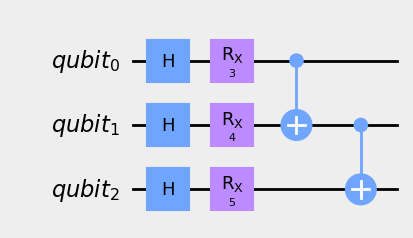

In [80]:
def build_circ(_circuit, _register, _params, _n_qubits, _barrier = False):
    """
    Implementación de un circuito parametrizado
    """

    for index in range(_n_qubits):
        # Añadimos una puerta de Hadamrd
        _circuit.h(index)
        # Implementamos una rotación sobre el je x
        _circuit.rx(_params[index], _register[index])

    # Añadimo puertas CNOT
    for k in range(_n_qubits - 1):
        # .cnot está deprecated desde la versión 0.45.0 de qiskit
        #_circuit.cnot(_register[k], _register[k+1])
        _circuit.cx(_register[k], _register[k+1])

    if _barrier:
        _circuit.barrier()

    return _circuit

# Ahora construimos los circuitos para |psi> and |phi>
nqubits = 3
nb_params = nqubits

# circuito para  |psi>
q = QuantumRegister(nqubits, 'qubit')
circ_psi = QuantumCircuit(q)
params_psi = [el for el in range( nb_params )]
circ_psi = build_circ(circ_psi, q, params_psi, nqubits)

# circuito para |phi>
p = QuantumRegister(nqubits, 'qubit')
circ_phi = QuantumCircuit(p)
params_phi = [el for el in range( nb_params, 2*nb_params)]
circ_phi = build_circ(circ_phi, p, params_phi, nqubits)

# Comentar esta línea si no se quiere dibujar el circuito
circuit_drawer(circ_phi, output='mpl', style={'backgroundcolor': '#EEEEEE'})

A continuación, construimos una función que medirá el qubit auxiliar 1000 veces y los promediará como se describe anteriormente (NOTA: Se ha tenido que hacer transpile inicialmente para eliminar error de ejecución):

```{index} transpile
```

In [81]:
def sigma_z(_circuit):
    """
    Takes in a circuit with an ancilla;
    returns the <sigma_z> of the measurements on the ancilla alone.
    """
    circuit_copy = _circuit.copy()
    c_reg = ClassicalRegister(1, "c_bit")
    circuit_copy.add_register(c_reg)

    circuit_copy.measure(0, c_reg[0])
    nb_shots = 10000

    simulator = Aer.get_backend("qasm_simulator")
    # esta instrucción está deprecated
    #job = execute(circuit_copy, backend=simulator, shots = nb_shots)
    transpiled =transpile(circuit_copy,simulator)
    job= simulator.run(transpiled, shots=nb_shots)
    result = job.result()
    counts = result.get_counts()

    return (counts['0'] - counts['1'])/nb_shots

Ahora podemos construir el operador U (la composición de $U_{\varphi}^{\dagger}U_{\Psi}$ que se muestra en los diagramas de circuito anteriores):

In [82]:
# para el circuito phi obtenemos U_phi^dagger
U_phi_dagger = circ_phi.to_gate(label = "U_phi^dagger").inverse()
definition = [ q[index] for index in range(nqubits) ]
# para el circuito psi
U_circ = circ_psi.copy()
# Añado ahora los dos circuitos
U_circ.append(U_phi_dagger, definition)

# Ahora construyo un control U
U_controlled_gate = (U_circ.to_gate(label = "U")).control(1)

In [83]:
U_controlled_gate = (U_circ.to_gate(label = "U")).control(1)

anc = QuantumRegister(1, 'ancilla')
q = QuantumRegister(nqubits, 'qubit')
circ_Hadamard = QuantumCircuit(anc, q)
definition = [anc[0]] + [q[index] for index in range(nqubits)]


evaluate_complex_part = False # cambiar a True si se quiere evaluar la parte imaginaria

circ_Hadamard.h(anc[0])
if evaluate_complex_part:
    circ_Hadamard.sdg(anc[0])

circ_Hadamard.append(U_controlled_gate, definition)
circ_Hadamard.h(anc[0])

# visualizo el circuito
circuit_drawer(circ_Hadamard, output='mpl', style={'backgroundcolor': '#EEEEEE'})

# mido el circuito auxiliar (anzila)
avg_Z = sigma_z(circ_Hadamard)
avg_Z

-0.2046

NOTA: el valor anterior puede cambiar pero estar cerca del mismo, ya que existe un factor de aleatoriedad que hay que tener en cuenta.

A continuación se muestra el ´código que sirve para evaluar de una forma analítica esta superposición

In [84]:
simulator = Aer.get_backend('aer_simulator')
circ_psi.save_statevector()
#job = execute(circ_psi, simulator)
job = simulator.run(transpile(circ_psi, simulator))
result = job.result()
psi_state = result.get_statevector()
psi_vector = psi_state.data

circ_phi.save_statevector()
#job = execute(circ_phi, simulator)
job = simulator.run(transpile(circ_phi, simulator))
result = job.result()
phi_state = result.get_statevector()
phi_vector = phi_state.data


phi_vector_dagger = phi_state.conjugate()
overlap = np.dot(phi_vector_dagger, psi_vector)
overlap

(-0.2107957994307797-0.9775301176650976j)

## Swap test

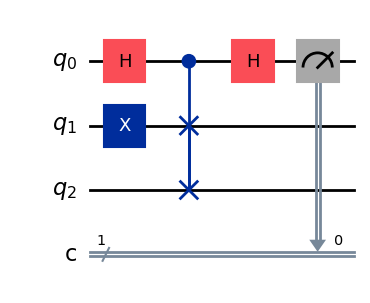

In [23]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer
from qiskit.visualization import plot_histogram

q = QuantumRegister(3,'q')
c = ClassicalRegister(1, 'c')

circuit = QuantumCircuit(q,c)

circuit.h(q[0])
circuit.x(q[1]) #comentar para hacer ambos estados no ortogonales
circuit.cswap(q[0],q[1],q[2]) #puerta controlada swap
circuit.h(q[0])
circuit.measure(q[0],c[0])

circuit.draw('mpl',style='iqp')


In [24]:
backend = Aer.get_backend('aer_simulator')
nShots = 8192
counts = backend.run(circuit,shots=nShots).result().get_counts()
counts

{'1': 4086, '0': 4106}

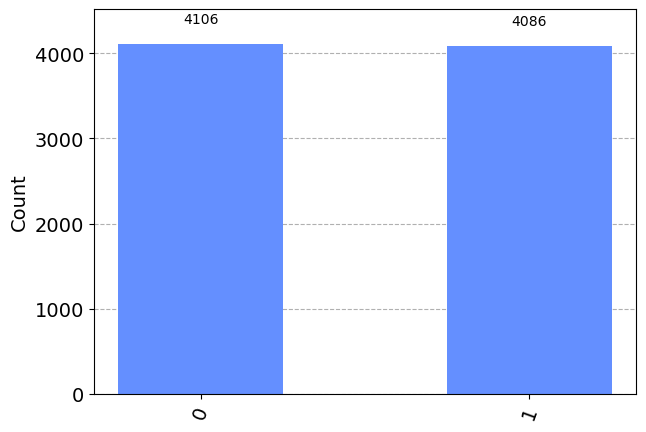

In [25]:
plot_histogram(counts)

In [26]:
if '1' in counts:
    b = counts['1']
else:
    b = 0


s = 1-(2/nShots)*(b)

print("módulo producto interno al cuadrado:",str(s))
print("Conteo: ",counts)

módulo producto interno al cuadrado: 0.00244140625
Conteo:  {'1': 4086, '0': 4106}


## Apéndice
```{index} density matrix, matriz de densidad
```


* <a href="https://www.youtube.com/watch?v=fDSqkt3cJvs" target="_blank"> Matriz de densidad </a>